**Trabajo Final del curso Deep Learning**

Author: Ing. Paolo Chunga Oblitas

# **Introduction**

Se ha extraido un dataset de 1,966 imágenes de comida, de las cuales 983 (50%) hacen referencia a imágenes de pizza, mientras que el resto son platillos variados que no son pizza. El objetivo de este script es crear un modelo de Deep Learning que nos ayude a clasificar cuáles de las imágenes que le entregamos al modelo son pizza y cuáles son otro platillo (menos pizza).


# **Distribución del dataset**
Estamos tomando un 90% del dataset para entrenar a nuestro modelo, una 2% para testear y un 8% para validación.

**Base libraries**

In [2]:
import os
import zipfile # Allows us to zip and unzip files
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model

## Getting dataset

**Mount our work directory**

In [3]:
from google.colab import drive
drive.mount('/content/drive/')
%cd '/content/drive/My Drive/Colab Notebooks/data/' 
%pwd

Mounted at /content/drive/
/content/drive/My Drive/Colab Notebooks/data


'/content/drive/My Drive/Colab Notebooks/data'

**Unzip dataset**

In [5]:
#!pip install patool
#import patoolib
#patoolib.extract_archive("dataset_pizza.rar", outdir="/content/drive/My Drive/Colab Notebooks/data/")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
patool: Extracting dataset_pizza.rar ...
patool: running /usr/bin/unrar x -- "/content/drive/My Drive/Colab Notebooks/data/dataset_pizza.rar"
patool:     with cwd='/content/drive/My Drive/Colab Notebooks/data/'


PatoolError: ignored

**Ubicarse en la carpeta extraida**

In [6]:
%cd 'dataset_pizza'

/content/drive/My Drive/Colab Notebooks/data/dataset_pizza


In [7]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/data/')

In [8]:
# Directories 
base_dir = 'dataset_pizza'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training benign melanoma pictures
train_benign_dir = os.path.join(train_dir, 'pizza')

# Directory with our training malignant melanoma pictures
train_malignant_dir = os.path.join(train_dir, 'not_pizza')

# Directory with our validation benign melanoma pictures
validation_benign_dir = os.path.join(validation_dir, 'pizza')

# Directory with our validation malignant melanoma pictures
validation_malignant_dir = os.path.join(validation_dir, 'not_pizza')

**Examples**

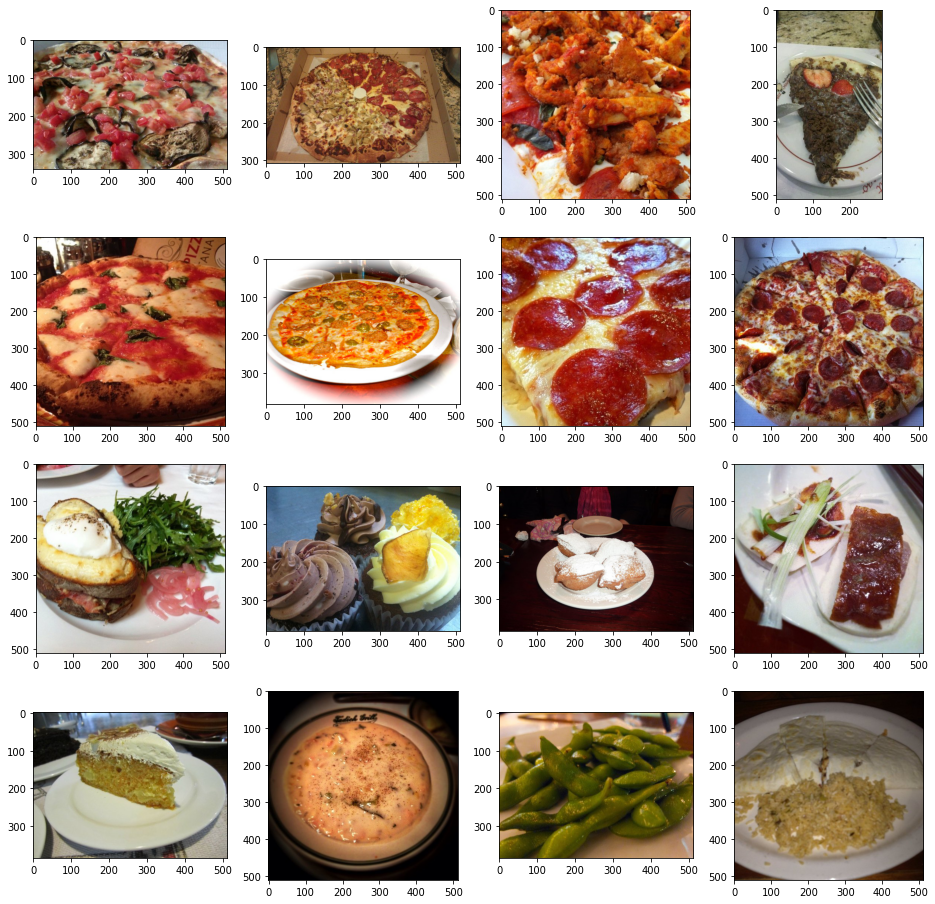

In [9]:
# Set up matplotlib fig, and size it to fit 4x4 pics
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 8
train_benign_fnames = os.listdir( train_benign_dir )
train_malignant_fnames = os.listdir( train_malignant_dir )


next_benign_pix = [os.path.join(train_benign_dir, fname) 
                for fname in train_benign_fnames[pic_index-8:pic_index] 
               ]

next_malignant_pix = [os.path.join(train_malignant_dir, fname) 
                for fname in train_malignant_fnames[pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_benign_pix + next_malignant_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i+1)
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Learning Process

**Preparing the dataset**

In what follows, we show the setting of the dataset to carry out the learning.

Notice that in order to improve the learning process, we have included sevarl option that allows us to increase the cardinality of our training dataset (**aumented dataset**) by means of sligth modifications.

```
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40, #rotation grade
                                   width_shift_range = 0.2, 
                                   height_shift_range = 0.2,
                                   shear_range = 0.2, #distortion along an axis 
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
```




In [10]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, #previously defined
                                                    batch_size = 32,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,  #previously defined
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 1760 images belonging to 2 classes.
Found 156 images belonging to 2 classes.


**Import the Inception model**

In what follows, we are going to load the pre-trained model that has been trained with a large set of images.

In [11]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [12]:
size_images=(150,150,3)
pre_trained_model = InceptionV3(input_shape = size_images, # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [13]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

It is necessary to indicate that all layers of pre-trained model will not be included in the learning process of our model

In [14]:
for layer in pre_trained_model.layers:
  layer.trainable = False

**Design our trainable neural network**



1.   We use the output of the pre-trained model as input of our model.
2.   We define a hidden layer with 16 neurons that include Relu as activation function
3. Finally, we add an output neuron that define the last layer for classification.






In [15]:
x = pre_trained_model.output
# Flatten the output layer to 1 dimension
x = layers.Flatten()(x)
# Add a fully connected layer with 16 hidden units and ReLU activation
x = layers.Dense(16, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.5)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           
model = Model(pre_trained_model.input, x) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

Additionally, it is necessary to define the **loss function** and the optimization algorithm for the process of **backpropagation** of our network. In this regard, we use:


1.   **Cross entropy** as loss function
2.   **Adam** as optimizer with a learning ratio of 0.0001





In [16]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer = Adam(learning_rate = 0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

**Flow images in batches of 20 using train _datagen and test_datagen**

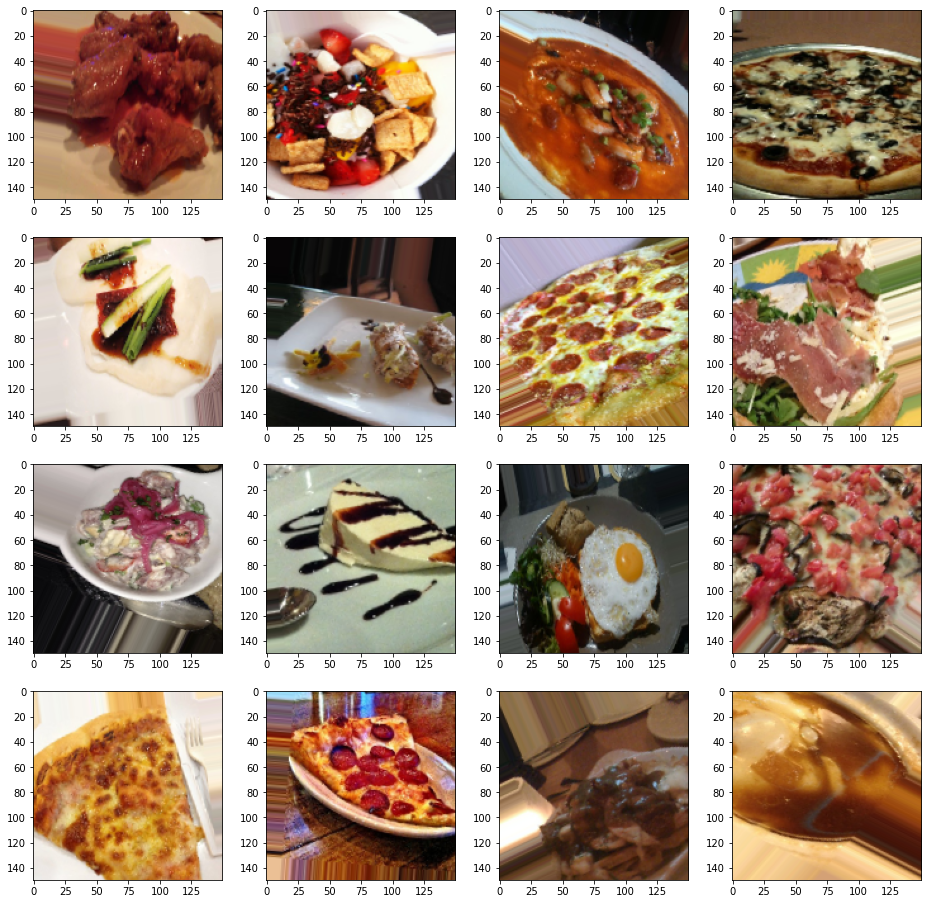

In [17]:
# Get a batch of augmented images from train_generator
augmented_images, _ = train_generator.next()

# Plot some augmented images
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16,16))
for i, ax in enumerate(axes.flat):
    ax.imshow(augmented_images[i])

plt.show()


**We start the training**

In [18]:
#callbacks = myCallback()
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size #1800/16=112.5
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size #100/1=100

history=model.fit(  train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=5
)


Epoch 1/5
55/55 [==============================] - 403s 7s/step - loss: 0.4692 - acc: 0.7767 - val_loss: 0.2274 - val_acc: 0.9071
Epoch 2/5
55/55 [==============================] - 117s 2s/step - loss: 0.3799 - acc: 0.8176 - val_loss: 0.1792 - val_acc: 0.9429
Epoch 3/5
55/55 [==============================] - 122s 2s/step - loss: 0.3509 - acc: 0.8574 - val_loss: 0.1906 - val_acc: 0.9286
Epoch 4/5
55/55 [==============================] - 119s 2s/step - loss: 0.3037 - acc: 0.8534 - val_loss: 0.1622 - val_acc: 0.9429
Epoch 5/5
55/55 [==============================] - 119s 2s/step - loss: 0.2993 - acc: 0.8642 - val_loss: 0.1908 - val_acc: 0.9214


**Plot Accuracy and Loss**

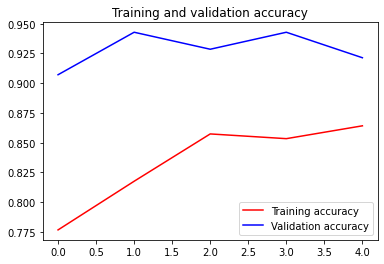

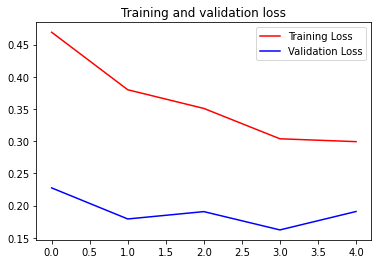

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Save model

In [20]:
# Guardar modelo
model.save('dmc_Paolo_Chunga_Pizza_modelo_Adam_150.h5')

## Testing Process

In [21]:
from keras.models import load_model
model = load_model('dmc_Paolo_Chunga_Pizza_modelo_Adam_150.h5')

In [23]:
pwd

'/content/drive/MyDrive/Colab Notebooks/data'

**Test with custom images**

In [26]:
from tensorflow.keras.preprocessing import image
import numpy as np
import glob

# Especificando el directorio que contiene las imágenes
img_dir = 'dataset_pizza/test/pizza/'
img_paths = glob.glob(img_dir + '*.jpg')

#contador 
cont_good = 0
cont_bad = 0

for path in img_paths:
    
    # Cargando la imagen en el tamaño requerido para el modelo
    img = image.load_img(path, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255

    prediction = model.predict(x, batch_size=10)

    if prediction[0] > 0.5:
        print(f"La imagen {path} es de otros platillos \n")
        cont_bad += 1
    else:
        print(f"La imagen {path}  es pizza \n")
        cont_good += 1
        

print('El modelo predice como imagenes de pizza: ', cont_good)
print('El modelo predice como imagenes de otros platillos: ', cont_bad)


1/1 [==============================] - 0s 144ms/step
La imagen dataset_pizza/test/pizza/3793314.jpg es de otros platillos 

1/1 [==============================] - 0s 144ms/step
La imagen dataset_pizza/test/pizza/3910117.jpg es de otros platillos 

1/1 [==============================] - 0s 145ms/step
La imagen dataset_pizza/test/pizza/3798959.jpg es de otros platillos 

1/1 [==============================] - 0s 187ms/step
La imagen dataset_pizza/test/pizza/3873326.jpg es de otros platillos 

1/1 [==============================] - 0s 135ms/step
La imagen dataset_pizza/test/pizza/3784357.jpg es de otros platillos 

1/1 [==============================] - 0s 138ms/step
La imagen dataset_pizza/test/pizza/3790235.jpg es de otros platillos 

1/1 [==============================] - 0s 157ms/step
La imagen dataset_pizza/test/pizza/3913912.jpg es de otros platillos 

1/1 [==============================] - 0s 153ms/step
La imagen dataset_pizza/test/pizza/3860002.jpg es de otros platillos 

1/1 [===